In [1]:
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import wrf 
import cartopy
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
import pandas as pd

mpl.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors)

In [3]:
from netCDF4 import Dataset
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
wrfinput = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/wrfinput_d01', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)

In [6]:
land_mask = wrfinput['LANDMASK'][0,:,:].T

In [8]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da

def rel_err(var_cs, var_vs):
    if np.any(var_vs == 0):
        result = np.zeros_like(var_cs)
    else:
        result = (var_cs - var_vs) / var_vs
    return - result*100

In [4]:
chi_spec = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_spec',sep=',',header=None)
chi_spec_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_spec_large',sep=',',header=None)
chi_spec_small = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_spec_small',sep=',',header=None)

chi_spec_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_spec_1km',sep=',',header=None)
chi_spec_large_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_spec_large_1km',sep=',',header=None)
chi_spec_small_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_spec_small_1km',sep=',',header=None)

# chi_ccn = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_ccn',sep=',',header=None)
# chi_ccn_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_ccn_large',sep=',',header=None)
# chi_ccn_small = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_ccn_small',sep=',',header=None)

# chi_ccn_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_ccn_1km',sep=',',header=None)
# chi_ccn_large_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_ccn_large_1km',sep=',',header=None)
# chi_ccn_small_1km = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/vars_total/chi_ccn_small_1km',sep=',',header=None)

In [5]:
def make_map(var_all, var_small, var_large, vmin, vmax,label,scale):
    var_list = [var_all, var_small, var_large]
    title = ['All',r'$D<100~\mathrm{nm}$',r'$D>100~\mathrm{nm}$']

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4),
                            subplot_kw=dict(projection=ccrs.PlateCarree()), 
                            gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    fig.subplots_adjust(right=0.9)  # Adjust the right margin for the colorbar

    for i, ax in enumerate(axs.flat):
        var_map = nc_shape(var_list[i]*land_mask)
        ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
        ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

        states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')

        ax.add_feature(states_provinces, edgecolor='black')
        ax.coastlines(resolution='50m', color='black', linewidth=1)
    
        var = var_list[i]
        if scale == 'log':
            im = ax.pcolormesh(lons, lats, var_map[:, :], norm = colors.LogNorm(vmin=vmin, vmax=vmax),  transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)                    
        else:
            im = ax.pcolormesh(lons, lats, var_map[:, :], vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)
        ax.set_title(title[i])

        position = fig.add_axes([0.92, 0.28, 0.02, 0.45])  # [left, bottom, width, height]
        cbar = plt.colorbar(im, ax=axs, cax=position)
        cbar.set_label(label)

    # plt.savefig('xxx.pdf', bbox_inches='tight')

In [9]:
ccn_cs_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_cs_large', sep=',', header=None)
ccn_vs_large = pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/ccn_vs_large', sep=',', header=None)
ccn_large_error     = rel_err(ccn_cs_large,     ccn_vs_large)

In [11]:
mask = ccn_large_error >= 40

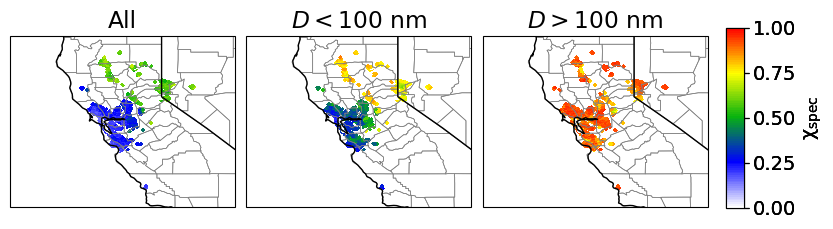

In [13]:
make_map(chi_spec.where(mask), chi_spec_small.where(mask), chi_spec_large.where(mask), 0, 1, r'$\rm \chi_{spec}$', 'linear')
plt.savefig('/data/keeling/a/xx24/d/proj_film/chi_spec.pdf', bbox_inches='tight', dpi=300)